In [1]:

!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt

Cloning into 'Quantum_KAN'...
remote: Enumerating objects: 882, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 882 (delta 8), reused 24 (delta 1), pack-reused 837
Receiving objects: 100% (882/882), 21.06 MiB | 9.75 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/Quantum_KAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install qiskit_experiments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.5/727.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 14.2 MB/s eta 0:00:00


In [3]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [4]:
import numpy as np

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [5]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)

In [6]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [7]:
%%time

from qiskit import pulse

sigma = 128
num_samples = 256

schedules = []

for amp in np.linspace(0., 1., 10):
    gauss = pulse.library.Gaussian(
        num_samples, amp, sigma, name="Parametric Gauss"
    )

    with pulse.build() as schedule:
        with pulse.align_sequential():
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.shift_phase(0.5, pulse.DriveChannel(0))
            pulse.shift_frequency(0.1, pulse.DriveChannel(0))
            pulse.play(gauss, pulse.DriveChannel(0))
            pulse.acquire(duration=1, qubit_or_channel=0, register=pulse.MemorySlot(0))

    schedules.append(schedule)

job = backend.run(schedules, shots=100)
result = job.result()

CPU times: user 3.19 s, sys: 224 ms, total: 3.41 s
Wall time: 6.79 s


In [8]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties

target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [9]:
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0,1, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,duration,(),sx,160.00,default,True,2024-06-18 06:13:18.370696+0000,None
1,β,(),sx,0.00,default,True,2024-06-18 06:13:18.370737+0000,None
2,amp,(),x,0.50,default,True,2024-06-18 06:13:18.370553+0000,None
3,σ,(),sx,40.00,default,True,2024-06-18 06:13:18.370670+0000,None
4,angle,(),x,0.00,default,True,2024-06-18 06:13:18.370587+0000,None
5,amp,(),sx,0.25,default,True,2024-06-18 06:13:18.370649+0000,None
6,angle,(),sx,0.00,default,True,2024-06-18 06:13:18.370717+0000,None
7,β,(),x,0.00,default,True,2024-06-18 06:13:18.370608+0000,None
8,duration,(),x,160.00,default,True,2024-06-18 06:13:18.370627+0000,None
9,σ,(),x,40.00,default,True,2024-06-18 06:13:18.370491+0000,None


In [10]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal([0], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal([1], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [11]:
%%time
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

CPU times: user 9.57 s, sys: 466 ms, total: 10 s
Wall time: 13.7 s


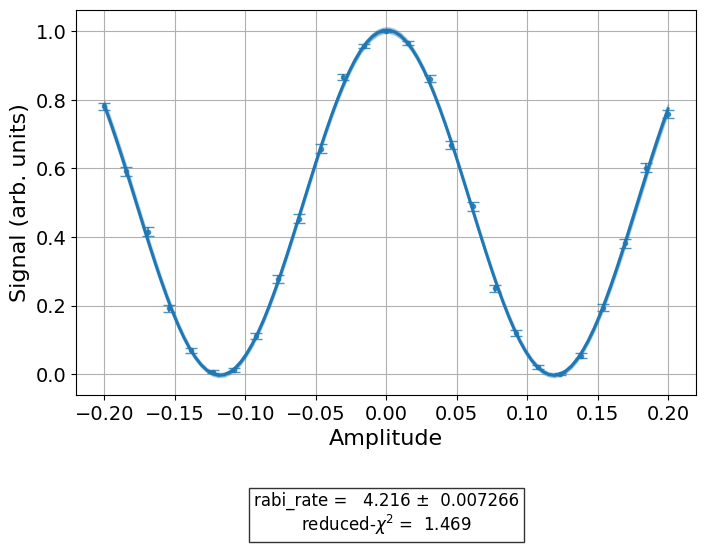

In [12]:
rabi0_data.figure(0)

In [13]:
# set the control channel map
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

In [14]:
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.500000,default,True,2024-06-18 06:13:18.370553+0000,None
1,amp,(),sx,0.250000,default,True,2024-06-18 06:13:18.370649+0000,None
2,amp,"(0,)",x,0.118590,default,True,2024-06-18 06:13:22.514861+0000,e2f48135-90e5-44c3-b266-a84b7498c193
3,amp,"(0,)",sx,0.059295,default,True,2024-06-18 06:13:22.514861+0000,e2f48135-90e5-44c3-b266-a84b7498c193


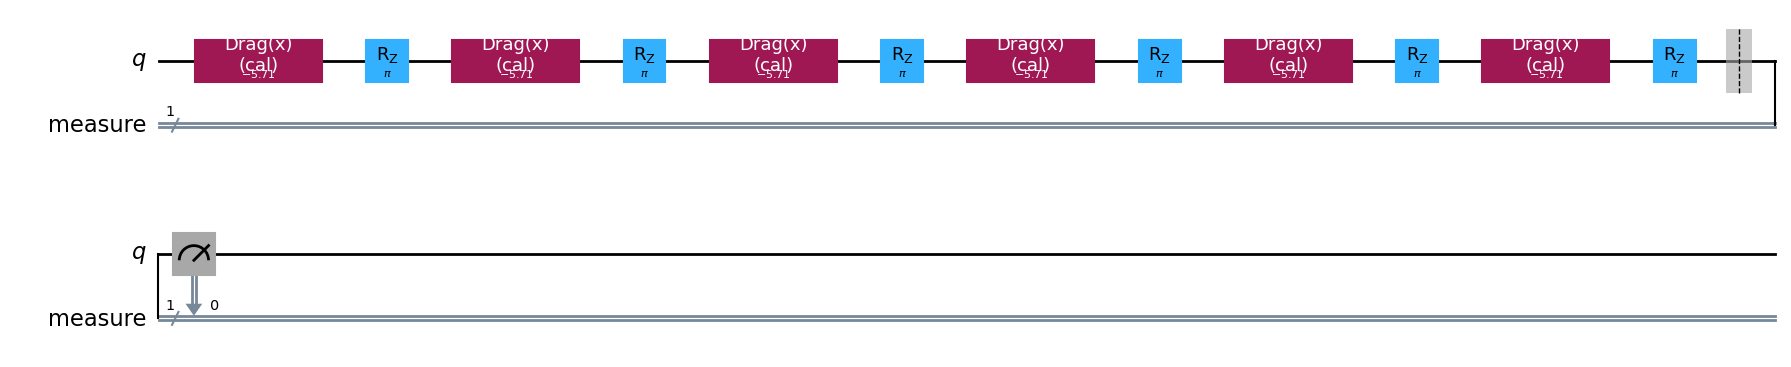

In [15]:
from qiskit_experiments.library.calibration import RoughDragCal

cal_drag0 = RoughDragCal([0], cals, backend=backend, betas=np.linspace(-20, 20, 15))
cal_drag1 = RoughDragCal([1], cals, backend=backend, betas=np.linspace(-20, 20, 15))

cal_drag0.set_experiment_options(reps=[3, 5, 7])
cal_drag1.set_experiment_options(reps=[3, 5, 7])

cal_drag0.circuits()[5].draw(output="mpl")

In [16]:
%%time
drag0_data = cal_drag0.run().block_for_results()
drag1_data = cal_drag1.run().block_for_results()

CPU times: user 38 s, sys: 6.9 s, total: 44.9 s
Wall time: 38.6 s


In [17]:
pd.DataFrame(**cals.parameters_table(qubit_list=[1, ()], parameters="amp"))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,"(1,)",sx,0.050457,default,True,2024-06-18 06:13:29.697142+0000,b333a44a-9759-4863-ab29-e2e57fe3be81
1,amp,(),x,0.500000,default,True,2024-06-18 06:13:18.370553+0000,None
2,amp,(),sx,0.250000,default,True,2024-06-18 06:13:18.370649+0000,None
3,amp,"(1,)",x,0.100915,default,True,2024-06-18 06:13:29.697142+0000,b333a44a-9759-4863-ab29-e2e57fe3be81


In [18]:
# set the control channel map
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

In [188]:
0.5*3/2

0.75

In [503]:
from qiskit.pulse import Schedule
from qiskit.pulse import Play, DriveChannel, ControlChannel,Drag
from qiskit.pulse import Gaussian,GaussianSquare
from qiskit.circuit.library import ECRGate
duration = 2000
sched_CNOT = Schedule(Play(GaussianSquare(duration=duration, sigma=64, width=duration-200, amp=0.6, angle=0.0),ControlChannel(0)))
sched_CNOT += Schedule(Play(GaussianSquare(duration=duration, sigma=64, width=duration-200, amp=0.00, angle=3.14),DriveChannel(1)))
"""
target.add_instruction(
    ECRGate(),
    {(0,1): InstructionProperties(calibration=sched_CNOT)}
)"""

'\ntarget.add_instruction(\n    ECRGate(),\n    {(0,1): InstructionProperties(calibration=sched_CNOT)}\n)'

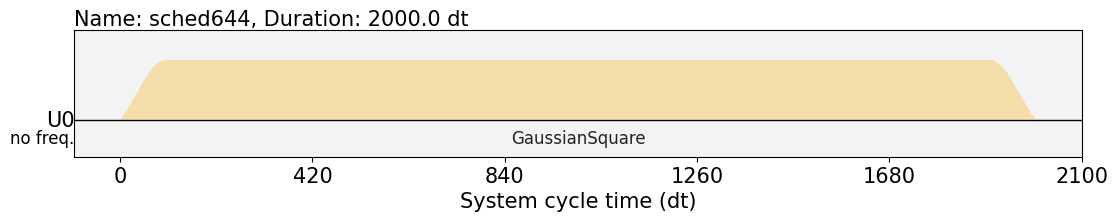

In [504]:
sched_CNOT.draw()

In [505]:
target.update_instruction_properties(
    'ecr',
    (0,1),
    InstructionProperties(calibration=sched_CNOT)
)

In [506]:
sch = target['ecr'][(0,1)].calibration

In [507]:
from qiskit_experiments.library import CrossResonanceHamiltonian

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())

In [508]:
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
circ = QuantumCircuit(2,1)
circ.x(0)
circ.ecr(0,1)
circ.x(0)
circ.ecr(0,1)
circ.measure(1,0)
passmanager = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[0,1])
circ = passmanager.run(circ)
%time result = backend.run(circ).result()

CPU times: user 1.35 s, sys: 11.4 ms, total: 1.37 s
Wall time: 1.36 s


In [524]:
import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# GHZ State preparation circuit
nq = 2
qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz.ecr(0,1)
# QST Experiment
qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(backend).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

AnalysisResult
- name: state
- value: DensityMatrix([[ 0.53198072+0.00000000e+00j,  0.00264585-7.56800608e-03j,
                -0.01090698-4.92652893e-01j, -0.01945817-1.97150431e-03j],
               [ 0.00264585+7.56800608e-03j,  0.00317837+0.00000000e+00j,
                 0.00561547-6.90087108e-03j, -0.00111447-1.73630256e-03j],
               [-0.01090698+4.92652893e-01j,  0.00561547+6.90087108e-03j,
                 0.46307688+0.00000000e+00j,  0.00471922-1.88136203e-02j],
               [-0.01945817+1.97150431e-03j, -0.00111447+1.73630256e-03j,
                 0.00471922+1.88136203e-02j,  0.00176403-5.42101086e-20j]],
              dims=(2, 2))
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: state_fidelity
- value: 0.0007348971912864134
- quality: unknown
- extra: <9 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- quality: unknown
- extra: <9 items>
- dev

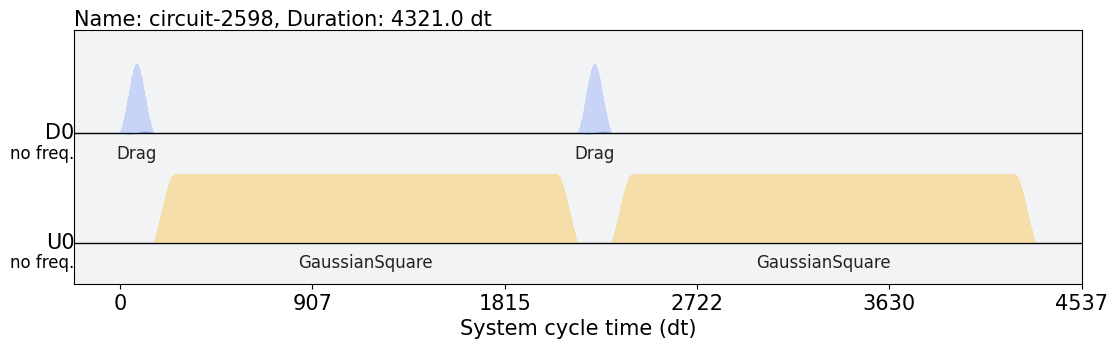

In [509]:
from qiskit import schedule as build_schedule  # Rename the import

build_schedule(circ, backend=backend).draw()  # Call the function using the new name

In [510]:
result.get_counts(0)

{'0': 19, '1': 1005}

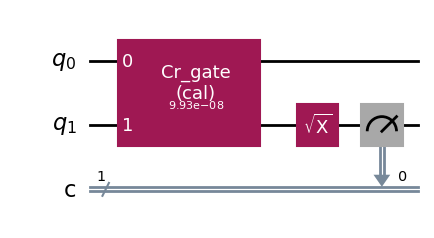

In [539]:
from qiskit_experiments.library import CrossResonanceHamiltonian

cr_ham_experiment = CrossResonanceHamiltonian(
    physical_qubits=(0, 1),
    durations=np.linspace(1e-7, 1e-6, 17),
    amp = 0.15,
    backend=backend
)

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())
cr_ham_experiment.circuits()[7].draw("mpl")

In [550]:
447-703

-256

In [551]:
194-450

-256

In [549]:
from qiskit import pulse,schedule
schedule(cr_ham_experiment.circuits()[9],backend=backend)

Schedule((0, Play(Drag(duration=160, sigma=40, beta=-1.605893834, amp=0.11859036, angle=0), DriveChannel(0))), (160, Delay(703, DriveChannel(0))), (160, Delay(703, DriveChannel(1))), (160, Play(GaussianSquare(duration=703, sigma=64, width=447, amp=0.15, angle=0.0), ControlChannel(0))), (863, ShiftPhase(1.5707963268, DriveChannel(1))), (863, ShiftPhase(1.5707963268, ControlChannel(0))), (863, Play(Drag(duration=160, sigma=40, beta=0, amp=0.05045731, angle=0), DriveChannel(1))), (1023, Acquire(1, AcquireChannel(1), MemorySlot(0))), name="circuit-5020")

In [540]:
%time data_cr = cr_ham_experiment.run().block_for_results()

CPU times: user 23 s, sys: 2.87 s, total: 25.9 s
Wall time: 22.9 s


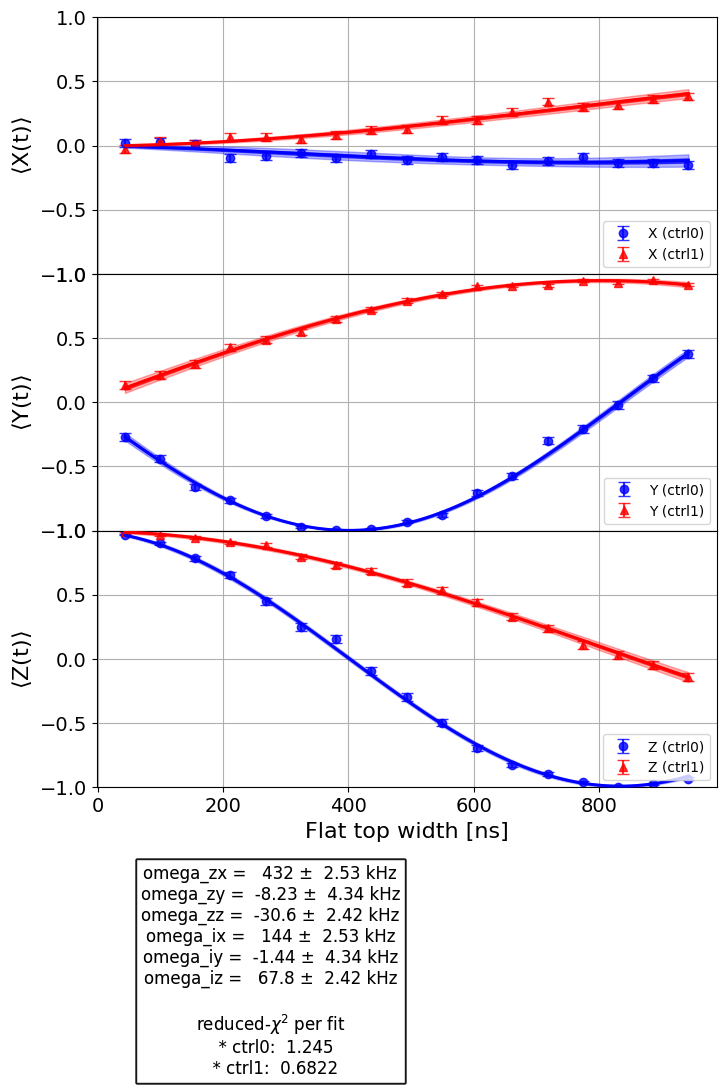

In [541]:
data_cr.figure(0)

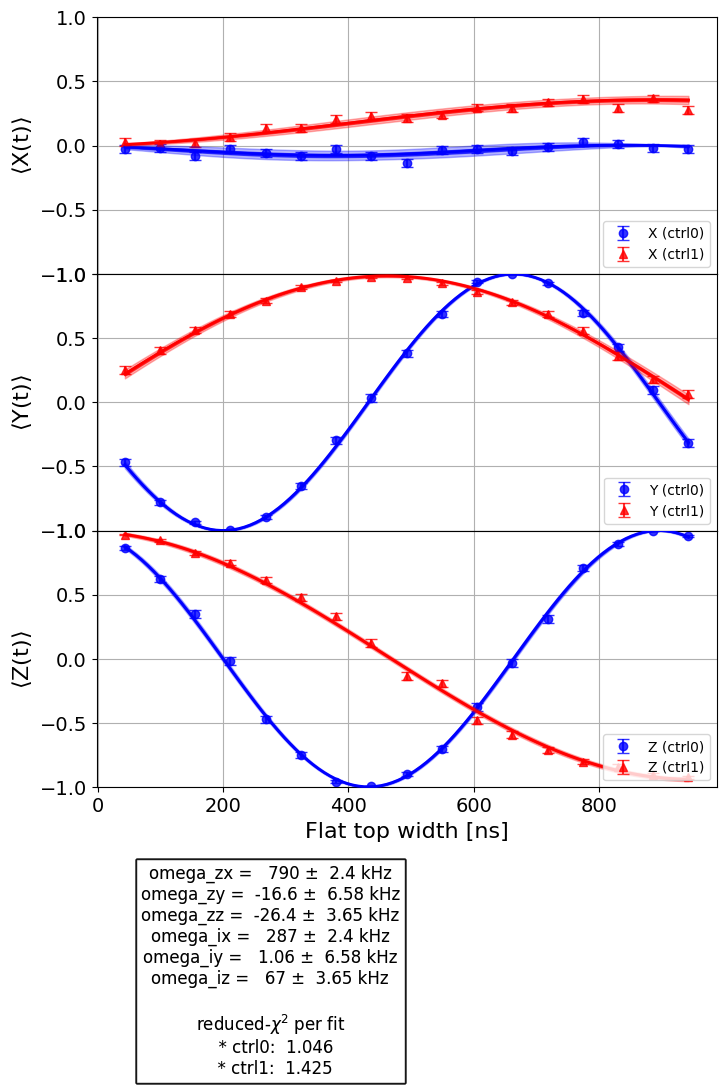

In [538]:
data_cr.figure(0)


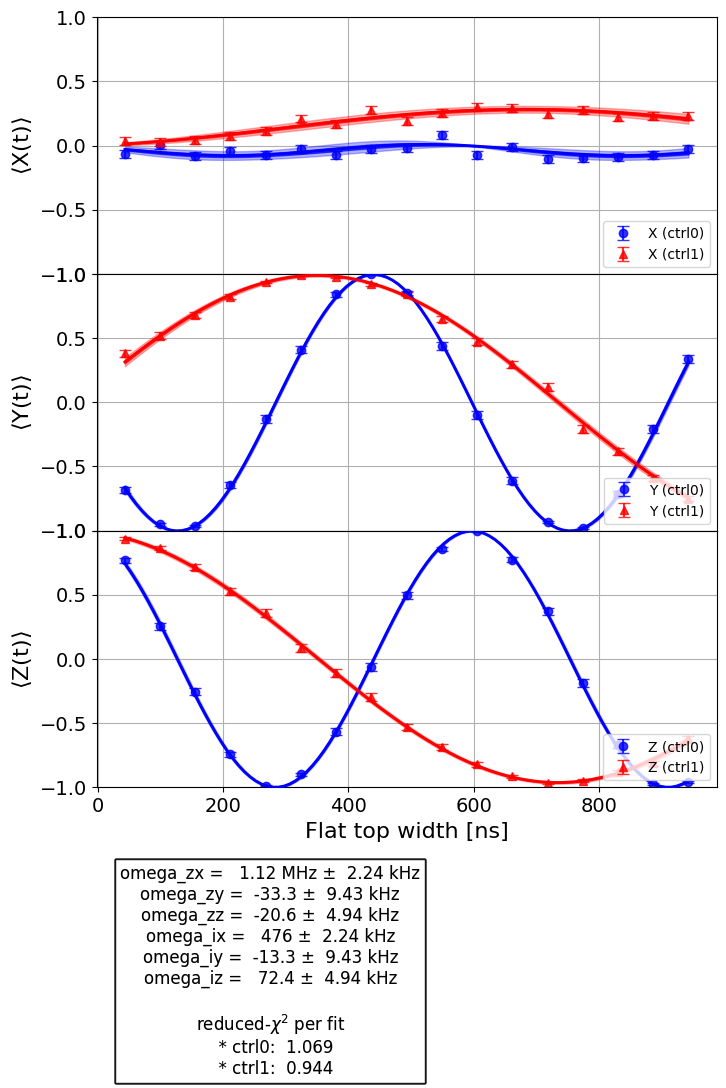

In [ ]:
data_cr.figure(0)
